In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

In [2]:
# Define the competition scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)

# Information about the challenge

In this challenge, the `requests` dataset contains information about the requests made by group of individuals (or family) to the french emergency housing public service. A sample of the `requests` dataset corresponds to a unique request.

The goal is to predict the categorical variable `granted_number_of_nights` which represents the number of nights of emergency housing granted to a group. You can train your model on the `train_requests`, the predictions should be made for requests listed in the `test_requests` dataset.

The evaluation metric is given by the `competition_scorer` defined above. It corresponds to a weighted log-loss with weights 1, 10, 100, or 1000 if the `granted_number_of_nights` takes the value 0, 1, 2, or 3 respectively. Thus beware that you will be penalized harder for classification mistakes made on the higher labels.

Good luck!

# Load the datasets

In [3]:
# Train sample
requests = pd.read_csv('data/train_requests.csv', sep=',', low_memory=False, error_bad_lines=False)

# Test sample
requests_test = pd.read_csv('data/test_requests.csv', sep=',', low_memory=False, error_bad_lines=False)

b'Skipping line 31303: expected 24 fields, saw 49\nSkipping line 75954: expected 24 fields, saw 49\n'


# Data description

In [4]:
requests.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
request_id,297739,297739,7c9eaa3100d955c51412e1120071449b,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
animal_presence,297739,2,f,296908,NaN,NaN,NaN,NaN,NaN,NaN,NaN
answer_creation_date,297739,277562,2019-01-01 07:00:00,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child_situation,297739,NaN,NaN,NaN,-0.321184,4.08921,-1,-1,-1,-1,70
child_to_come,115453,2,f,107529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
district,297739,NaN,NaN,NaN,7045.22,46442.4,1,35,61,81,315842
granted_number_of_nights,297739,NaN,NaN,NaN,0.688526,0.769463,0,0,1,1,3
group_composition_id,297739,NaN,NaN,NaN,27.9082,28.8707,-1,10,10,40,120
group_composition_label,297738,12,man alone,163208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
group_creation_date,297738,61766,2017-07-17 00:00:00.000,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Inspect basic metadata about the dataset
requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297739 entries, 0 to 297738
Data columns (total 24 columns):
request_id                       297739 non-null object
animal_presence                  297739 non-null object
answer_creation_date             297739 non-null object
child_situation                  297739 non-null int64
child_to_come                    115453 non-null object
district                         297739 non-null int64
granted_number_of_nights         297739 non-null int64
group_composition_id             297739 non-null int64
group_composition_label          297738 non-null object
group_creation_date              297738 non-null object
group_id                         297739 non-null object
group_main_requester_id          297739 non-null object
group_type                       297738 non-null object
housing_situation_id             297739 non-null int64
housing_situation_label          276802 non-null object
long_term_housing_request        90926 non-null object

# Data cleaning

In [6]:
requests['child_to_come'].fillna('f', inplace=True)
requests['group_composition_label'].fillna('man alone', inplace=True)
requests['group_type'].fillna('individual', inplace=True)
requests['housing_situation_label'].fillna('street', inplace=True)
requests['victim_of_violence'].fillna('f', inplace=True)

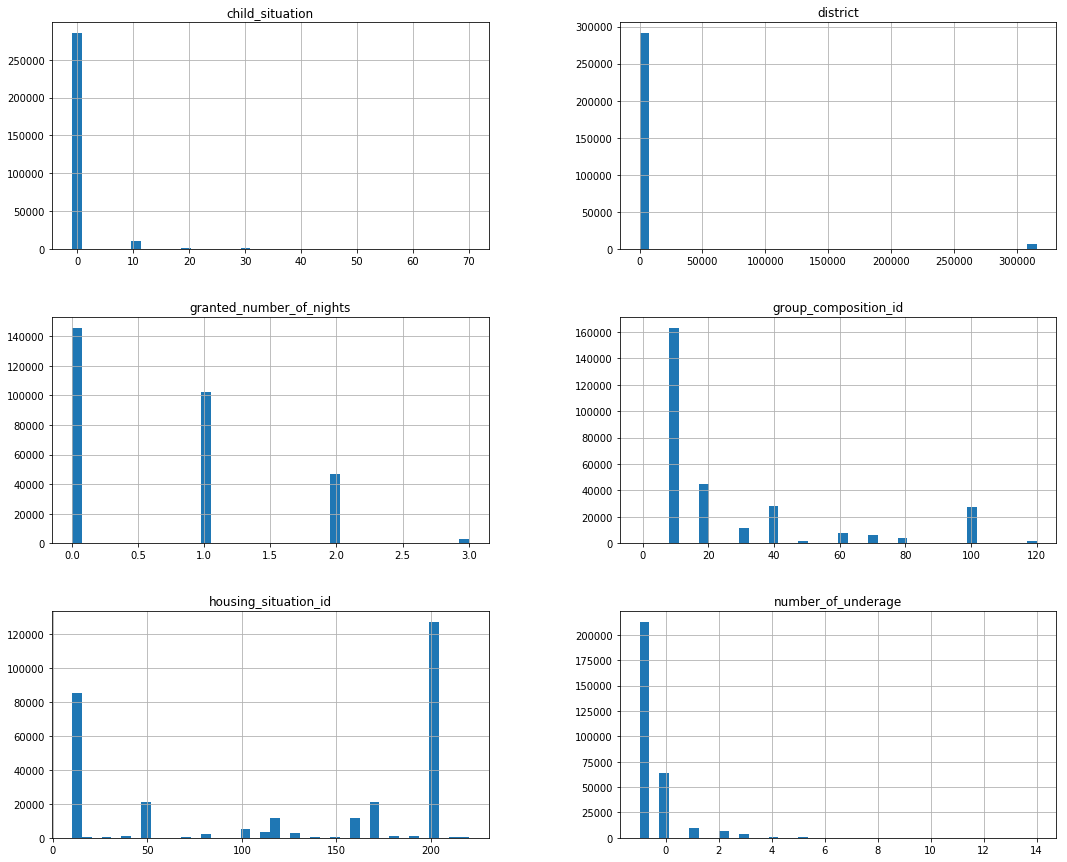

In [7]:
requests.hist(bins=40, figsize=(18, 15))
plt.show()

In [8]:
# selected columns for explanatory variable
columns = ['child_situation',
           'district',
           'housing_situation_id',
           'group_composition_id',
           'number_of_underage']

X = requests[columns]
y = requests['granted_number_of_nights']

In [9]:
# split between the train and the validation samples
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

# 4-Train and evaluate a first model

Logistic regression

In [10]:
# use logistic regression as first model
lr_clf = LogisticRegression(solver='liblinear', multi_class='auto', random_state=42)

In [11]:
# fit the model
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
# evaluate the model with the competition scorer (validation set)
competition_scorer(y_val, lr_clf.predict_proba(X_val))

2.4660745542202394

SVM

In [ ]:
svc_clf = SVC(random_state=42)
svc_clf.fit(X_train, y_train)

In [ ]:
competition_scorer(y_val, svc_clf.predict_proba(X_val))

Decision Trees

In [13]:
dt_clf = DecisionTreeClassifier(random_state=42, max_leaf_nodes=4)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [14]:
competition_scorer(y_val, dt_clf.predict_proba(X_val))
# competition_scorer(y_val, dt_clf.best_estimator_.predict_proba(X_val))

2.358821546241229

Random Forest

In [15]:
# rdmFrst_params = {'max_features': [4],
#                   'min_samples_split': [2, 3, 10],
#                   'min_samples_leaf': [1, 3, 10],
#                   'bootstrap': [False],
#                   'n_estimators':[100, 300],
#                   'criterion': ['gini']}
# rdmFrst_gridsearch = GridSearchCV(RandomForestClassifier(random_state=42),
#                                   rdmFrst_params,
#                                   cv=StratifiedKFold(n_splits=10),
#                                   scoring='accuracy',
#                                   n_jobs=-1)
rdmFrst_clf = RandomForestClassifier(random_state=42, max_features=4)
rdmFrst_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [16]:
competition_scorer(y_val, rdmFrst_clf.predict_proba(X_val))

3.5884667274060553

Adaboost

In [17]:
# Inspired by https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
# ada_params = {
#     'base_estimator__criterion': ['gini', 'entropy'],
#               'base_estimator__splitter': ['best', 'random'],
#               'algorithm': ['SAMME', 'SAMME.R'],
#               'n_estimators': [1, 2],
#               'learning_rate': [0.01, 0.1]}

# ada_gridsearch = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state=42)),
#                               param_grid = ada_params,
#                               cv=StratifiedKFold(n_splits=10),
#                               scoring='accuracy',
#                               n_jobs=-1)

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=42, max_leaf_nodes=4))
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [18]:
competition_scorer(y_val, ada_clf.predict_proba(X_val))

1.360324494755825

Extra Trees

In [19]:
# extraTree_params = {'max_depth': [None],
#                     'max_features': [1, 3, 10],
#                     'min_samples_split': [2, 3, 10],
#                     'min_samples_leaf': [1, 3, 10],
#                     'bootstrap': [False],
#                     'n_estimators': [100, 300],
#                     'criterion': ['gini']}
# extraTree_gridsearch = GridSearchCV(ExtraTreesClassifier(random_state=42),
#                                     extraTree_params,
#                                     cv=StratifiedKFold(n_splits=10),
#                                     scoring='accuracy',
#                                     n_jobs=-1)
extraTree_clf = ExtraTreesClassifier(random_state=42, max_features=4)
extraTree_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
competition_scorer(y_val, extraTree_clf.predict_proba(X_val))

3.97846355315819

Gradient Boosting

In [21]:
# gbrt_params = {'n_estimators': [100, 200, 300],
#                'loss': ['deviance'],
#                'learning_rate': [0.01, 0.05, 0.1],
#                'max_depth': [5],
#                'min_samples_leaf': [100, 150],
#                'max_features': [0.1, 0.3]}
# gbrt_gridsearch = GridSearchCV(GradientBoostingClassifier(random_state=42),
#                                gbrt_params,
#                                cv=StratifiedKFold(n_splits=10),
#                                scoring='accuracy',
#                                n_jobs=-1)
gbrt_clf = GradientBoostingClassifier(random_state=42, max_features=4)
gbrt_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [22]:
competition_scorer(y_val, gbrt_clf.predict_proba(X_val))

1.8429466722394838

Voting classifier

In [23]:
voting_soft_clf = VotingClassifier(
    estimators=[
                ('lr', lr_clf),
#                 ('svm', svr_gridsearch),
                ('dt', dt_clf),
                ('rf', rdmFrst_clf),
                ('ada', ada_clf),
                ('extraTree', extraTree_clf),
                ('gbrt', gbrt_clf)
    ],
    voting='soft'
)

voting_soft_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('dt', Decis...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [24]:
competition_scorer(y_val, voting_soft_clf.predict_proba(X_val))

1.5428309332469614

# 5- Compute predictions on the test set 

In [ ]:
# use the model to predict on the test set
X_test = requests_test[columns]
y_pred = ada_clf.predict_proba(X_test)

In [ ]:
# overview of prediction probabilities for first four rows
y_pred[:4]

In [ ]:
predictions = pd.concat([requests_test['request_id'], pd.DataFrame(y_pred)], axis=1)

# 6- Submit your predictions to the QScore platform

In [ ]:
import io, math, requests

# Get your token from qscore:
# 1. Go to https://qscore.datascience-olympics.com/
# 2. Chose the competition Data Science Olympics 2019
# 3. In the left menu click 'Submissions'
# 4. Your token is in the 'Submit from your Python Notebook' tab

def submit_prediction(df, sep=',', comment='', compression='gzip', **kwargs):
    TOKEN='f621f6e9426b924e64f819e48aa2782e2426bab78a7b7dca8b1224dff5be734a6e18167266adf7e04f51dfbfa22db6c3633c0362c3d7c769ae210a8fa1a97670'
    URL='https://qscore.datascience-olympics.com/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [ ]:
submit_prediction(predictions, sep=',', index=False, comment='my submission')